## Initizalize environment


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random as rn
import glob
from skimage.transform import resize
import numpy as np
from keras.models import Sequential
from keras.models import Model
from tqdm import tqdm
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
GPU_ID = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = GPU_ID

from keras import backend as K
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, add, concatenate, Lambda, Flatten, Conv2DTranspose
from tensorflow.python.keras import backend as K

# adjust values to your needs
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

import time

from natsort import natsorted

import cv2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, LearningRateScheduler

FACTOR = 2

NUM_CLASSES = 12

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
with tf.device('/device:GPU:0'):

  CLASSES_BGR = ((0, 255, 0), (0, 255, 255), (255, 255, 255), (127, 127, 127), (255, 255, 255), (255, 0, 255), (127, 127, 127), (255, 0, 0), (255, 255, 0), (63, 127, 127), (0, 0, 255), (0, 127, 127))

  from safeuav import get_unet_MDCB_with_deconv_layers

  original_width = 4096
  original_height = 2160

  input_width = int(original_width / FACTOR)
  input_height = int(original_height / FACTOR)

  batch_size = 1

Found GPU at: /device:GPU:0


In [ ]:
# for file in sorted(glob.glob('./CV_project_copy/data/Augmented_data/*.npz')):
#   label = np.load(file)['arr_0']
#   label = np.round(resize(label, (input_height, input_width), mode='constant', anti_aliasing=False))
#   break
# path, dirs, files = next(os.walk("./CV_project_copy/data/Augmented_data"))
# file_count = len(files)
# print(file_count)
# Y = np.empty((int(file_count/2), np.shape(label)[0], np.shape(label)[1], np.shape(label)[2]))
# print(np.shape(Y))

## Import labels


In [ ]:
# i = 0
# Y = []
# for file in sorted(glob.glob('./CV_project_copy/data/Augmented_data/*.npz')):
#   label = np.load(file)['arr_0']
#   label = np.round(resize(label, (input_height, input_width), mode='constant', anti_aliasing=False))
#   Y.append(label.astype(bool))
#   del label
#   print(file)
# print(np.shape(Y))


## Import input

In [ ]:
# photos = [cv2.imread(file) for file in sorted(glob.glob('./CV_project_copy/data/Augmented_data/*.png'))]
# X = []
# for photo in range(np.shape(photos)[0]):
#     input_img = cv2.resize(photos[photo], (input_width, input_height))
#     X.append(input_img)
# print(np.shape(X))
# print(X[0][0][0])

# x_batch = np.array(x_batch).reshape(-1, input_height, input_width, 3)
# y_batch = np.array(y_batch).reshape(-1, input_height, input_width, 3)
# labels = np.empty((y_batch.shape[0], y_batch.shape[1], y_batch.shape[2], 2))
# print(labels.shape)
# for nr_img in range(y_batch.shape[0]):
#     print(nr_img)
#     labels[nr_img] = [[(lambda pix : [1, 0] if pix[1] > 80 and pix[0] < 150  else [0, 1])(y_batch[nr_img][w][h]) for h in range(y_batch.shape[2])] for w in range(y_batch.shape[1])]





##Test labels to be correct

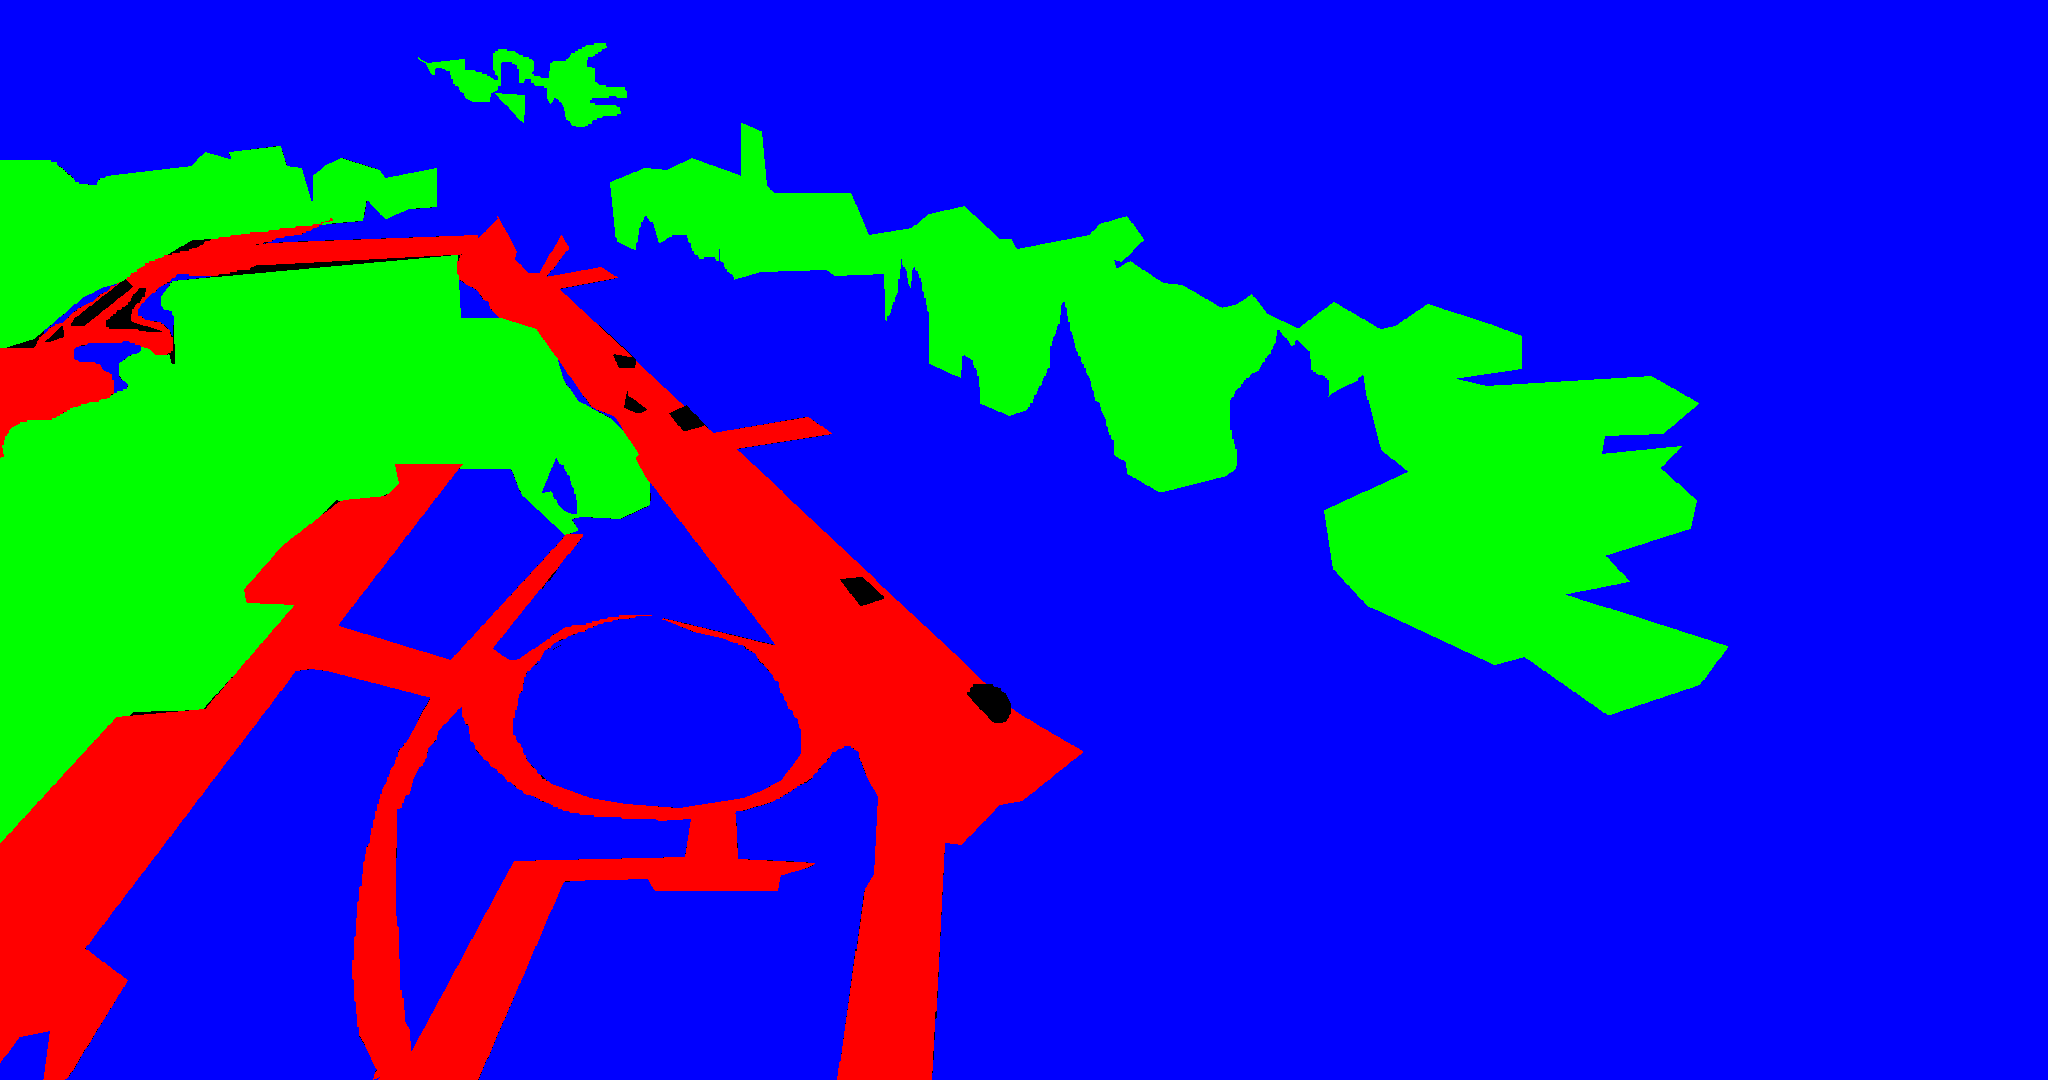

NameError: ignored

In [ ]:
# from google.colab.patches import cv2_imshow
# poza = np.zeros((1080,2048,3))
# for i in range(1080):
#   for j in range(2048):
#     if Y[0][i][j][0] == 1:
#       poza[i][j][0] = 255
#     if Y[0][i][j][1] == 1:
#       poza[i][j][1] = 255
#     if Y[0][i][j][2] == 1:
#       poza[i][j][2] = 255
# cv2_imshow( poza)
# cv2_imshow(X[0])


##Create network

In [ ]:
from keras.optimizers import RMSprop
from losses import bce_dice_loss, dice_coeff
FACTOR = 2

NUM_CLASSES = 12

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
with tf.device('/device:GPU:0'):

  #labels = {'land', 'forest', 'residential', 'capitze', 'road', 'church', 'cars', 'water', 'sky', 'hill', 'person', 'fence'};
  # CLASSES_BGR = ((0, 255, 0), (255, 0, 0), (0, 255, 255), (0, 127, 255), (255, 255, 255), (255, 0, 255), (127, 127, 127), (255, 0, 0), (255, 255, 0), (63, 127, 127), (0, 0, 255), (0, 127, 127))
  CLASSES_BGR = ((0, 255, 0), (0, 255, 255), (255, 255, 255), (127, 127, 127), (127, 0, 63), (255, 0, 255), (127, 0, 127), (255, 0, 0), (255, 255, 0), (63, 127, 127), (0, 0, 255), (0, 127, 127))

  from safeuav import get_unet_MDCB_with_deconv_layers

  original_width = 4096
  original_height = 2160

  input_width = int(original_width / FACTOR)
  input_height = int(original_height / FACTOR)

  batch_size = 1

  DATA_PATH = './CV_project_copy/ruralscapes-nn-main/data/rgb_frames/Gura_Portitei_1_test'

  # baseline
  # WEIGHTS_PATH = './CV_HM4/ruralscapes-nn-main (1)/ruralscapes-nn-main/weights/safeuav/gt_only_2seconds_standard_augmentation/EPOCH_153_TRAIN_loss_0.21953_dice_0.8511_VALID_loss_0.34358_dice_0.7740.hdf5' 

  # segprop - with denoise
  # WEIGHTS_PATH = './CV_project_copy//ruralscapes-nn-main/weights/safeuav/segprop_interp_all_standard_augmentation/with_denoise/EPOCH_13_TRAIN_loss_0.03721_dice_0.9745_VALID_loss_0.24476_dice_0.8702.hdf5'

  # segprop - without denoise
  WEIGHTS_PATH = './CV_project_copy/ruralscapes-nn-main/weights/safeuav/segprop_interp_all_standard_augmentation/without_denoise/EPOCH_18_TRAIN_loss_0.03984_dice_0.9727_VALID_loss_0.24240_dice_0.8683.hdf5'


  modelInit = None
  modelInit = get_unet_MDCB_with_deconv_layers(input_shape=(input_height, input_width, 3), init_nb=24, lr=0.0001, num_classes=NUM_CLASSES)
  # modelInit.summary()
  # print('=================')
  modelInit.load_weights(WEIGHTS_PATH)
  popped_layer = modelInit._layers.pop()
  # modelInit.summary()
  modelInit.trainable = False
  model = None
  model = Sequential()
  model.add(modelInit)
  model.add(layers.Conv2D(4, (1, 1), activation='sigmoid'))
  # model.add(layers.Dense(4, activation = 'sigmoid'))
  for layer in model.layers:
    layer.trainable = False
  model.compile(optimizer=RMSprop(lr=0.01), loss=bce_dice_loss, metrics=[dice_coeff])
  model.load_weights('./CV_project_copy/ruralscapes-nn-main/good_boy_model_with_pop.hdf5')

  # Xc = np.array(X).reshape(-1, input_height , input_width, 3) / 255
  # Yc = np.array(Y).reshape(-1, input_height , input_width, 4)
  # print(np.shape(Yc))


  # opt = keras.optimizers.Adam(learning_rate=0.01)
  # model.compile(loss='binary_crossentropy',
  #             optimizer=opt,
  #             metrics=['accuracy'])    
  # # for epoch in range(2):
  # #   # for i in range(0,x_batch.shape[0]-2,2):
  # #   for i in range(np.shape(X)[0]):
  # #   # for i in range(4):
  # #     print(np.expand_dims(X[i],axis = 0).shape)
  # #     # model.fit(x_batch[i:i+2],labels[i:i+2],batch_size = 3, epochs=1)
  # #     model.fit(np.expand_dims(X[i],axis = 0),np.expand_dims(Y[i],axis = 0),batch_size = 1, epochs=1)
  # for layer in model.layers:
  #   # layer.trainable = True
  #   print("{}: {}".format(layer, layer.trainable))
  # model.summary()
  # model.fit(Xc,Yc, batch_size = 5, epochs=10, shuffle=True,)
  # for layer in model.layers:
  #   layer.trainable = False
  #   print("{}: {}".format(layer, layer.trainable))
  # model.summary()
  # model.fit(Xc,Yc, batch_size = 5, epochs=2, shuffle=True,)


Found GPU at: /device:GPU:0


In [ ]:
for layer in model.layers:
  layer.trainable = False

In [ ]:
NUM_CLASSES = 2
DATA_PATH = './CV_HM4/Train_frames/Delta_Crisan_1/Augmented_data/'
epochs = 10
batch_size = 2
model.compile(optimizer=RMSprop(lr=0.01), loss=bce_dice_loss, metrics=[dice_coeff])

OUTPUT_WEIGHTS = os.path.join('weights', 'seg', 'gt_only_2seconds_standard_augmentation')
if not os.path.exists(OUTPUT_WEIGHTS):
    os.makedirs(OUTPUT_WEIGHTS)

# train_files = open(os.path.join(DATA_PATH, 'train.txt')).read().splitlines()
# valid_files = open(os.path.join(DATA_PATH, 'valid.txt')).read().splitlines()
# train_files = []

# ids_train_split = rn.sample(train_files, len(train_files)) 
# ids_valid_split = rn.sample(valid_files, len(valid_files)) 

ids_train_split = rn.sample(range(80), len(range(80))) 
ids_valid_split = rn.sample(range(80, 100), len(range(80, 100)))

print('Training on {} samples'.format(len(ids_train_split)))
print('Validating on {} samples'.format(len(ids_valid_split)))

with tf.device('/device:GPU:0'):
  def randomHueSaturationValue(image, hue_shift_limit=(-180, 180),
                              sat_shift_limit=(-255, 255),
                              val_shift_limit=(-255, 255), u=0.5):
      if np.random.random() < u:
          image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
          h, s, v = cv2.split(image)
          hue_shift = np.random.uniform(hue_shift_limit[0], hue_shift_limit[1])
          h = cv2.add(h, hue_shift)
          sat_shift = np.random.uniform(sat_shift_limit[0], sat_shift_limit[1])
          s = cv2.add(s, sat_shift)
          val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
          v = cv2.add(v, val_shift)
          image = cv2.merge((h, s, v))
          image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

      return image

  def randomShiftScaleRotate(image, mask,
                            shift_limit=(-0.0625, 0.0625),
                            scale_limit=(-0.1, 0.1),
                            rotate_limit=(-45, 45), aspect_limit=(0, 0),
                            borderMode=cv2.BORDER_CONSTANT, u=0.5):
      if np.random.random() < u:
          height, width, channel = image.shape

          angle = np.random.uniform(rotate_limit[0], rotate_limit[1])  # degree
          scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
          aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
          sx = scale * aspect / (aspect ** 0.5)
          sy = scale / (aspect ** 0.5)
          dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
          dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)

          cc = np.math.cos(angle / 180 * np.math.pi) * sx
          ss = np.math.sin(angle / 180 * np.math.pi) * sy
          rotate_matrix = np.array([[cc, -ss], [ss, cc]])

          box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
          box1 = box0 - np.array([width / 2, height / 2])
          box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

          box0 = box0.astype(np.float32)
          box1 = box1.astype(np.float32)
          mat = cv2.getPerspectiveTransform(box0, box1)
          image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                      borderValue=(
                                          0, 0,
                                          0,))
          mask = cv2.warpPerspective(mask, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                    borderValue=(
                                        0, 0,
                                        0,))

      return image, mask


  def randomHorizontalFlip(image, mask, u=0.5):
      if np.random.random() < u:
          image = cv2.flip(image, 1)
          mask = cv2.flip(mask, 1)

      return image, mask

  def train_generator():
      while True:
          for start in range(0, len(ids_train_split), batch_size):
              x_batch = []
              y_batch = []
              end = min(start + batch_size, len(ids_train_split))
              ids_train_batch = ids_train_split[start:end]
              for id in ids_train_batch:
                  # idsplit = id.split('_')
                  # video_name = idsplit[0] + '_' + idsplit[1]
                  img = cv2.imread(os.path.join(DATA_PATH, str(id).zfill(3) + '.png'))
                  # print(os.path.join(DATA_PATH, str(id).zfill(3) + '.png'))
                  # print(np.shape(img))

                  img = cv2.resize(img, (input_width, input_height))
                  
                  img = randomHueSaturationValue(img,
                                                hue_shift_limit=(-50, 50),
                                                sat_shift_limit=(-5, 5),
                                                val_shift_limit=(-15, 15))
                  
                  label = np.load(os.path.join(DATA_PATH, str(id).zfill(3) + '_label.npz'))['arr_0']
                  label_resized = resize(label, (input_height, input_width), mode='constant', anti_aliasing=True)

                  img, multi_label = randomShiftScaleRotate(img, label_resized,
                                                  shift_limit=(-0.0625, 0.0625),
                                                  scale_limit=(-0.1, 0.1),
                                                  rotate_limit=(-0, 0))
                  img, multi_label = randomHorizontalFlip(img, multi_label)

                  x_batch.append(img)
                  y_batch.append(multi_label)
                      
              x_batch = np.array(x_batch, np.float32) / 255
              y_batch = np.array(y_batch, np.float32)
              
              yield x_batch, y_batch


  def valid_generator():
      while True:
          for start in range(0, len(ids_valid_split), batch_size):
              x_batch = []
              y_batch = []
              end = min(start + batch_size, len(ids_valid_split))
              ids_valid_batch = ids_valid_split[start:end]
              for id in ids_valid_batch:
                  # idsplit = id.split('_')
                  # video_name = idsplit[0] + '_' + idsplit[1]
                  img = cv2.imread(os.path.join(DATA_PATH, str(id).zfill(3) + '.png'))
                  # print(np.shape(img))
                  img = cv2.resize(img, (input_width, input_height))

                  # Labels from Dragos
                  label = np.load(os.path.join(DATA_PATH, str(id).zfill(3) + '_label.npz'))['arr_0']
                  label_resized = resize(label, (input_height, input_width), mode='constant', anti_aliasing=True)
              
                  x_batch.append(img)
                  y_batch.append(label_resized)
              
              x_batch = np.array(x_batch, np.float32) / 255

              y_batch = np.array(y_batch, np.float32) 
              
              yield x_batch, y_batch

  callbacks = [EarlyStopping(monitor='val_loss',
                            patience=7,
                            verbose=1,
                            min_delta=1e-6),
              ReduceLROnPlateau(monitor='val_loss',
                                factor=0.1,
                                patience=5,
                                verbose=1,
                                epsilon=1e-6),
              ModelCheckpoint(monitor='val_loss',
                              filepath=os.path.join(OUTPUT_WEIGHTS, 'EPOCH_{epoch:02d}_TRAIN_loss_{loss:.5f}_dice_{dice_coeff:.4f}_VALID_loss_{val_loss:.5f}_dice_{val_dice_coeff:.4f}.hdf5'),
                              save_best_only=False,
                              save_weights_only=True,
                              period=1),
              TensorBoard(log_dir='logs')]

  model.fit_generator(generator=train_generator(),
                      steps_per_epoch=np.ceil(float(len(ids_train_split)) / float(batch_size)),
                      epochs=epochs,
                      verbose=1,
                      callbacks=callbacks,
                      validation_data=valid_generator(),
                      validation_steps=np.ceil(float(len(ids_valid_split)) / float(batch_size)))


Training on 80 samples
Validating on 20 samples


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
40/40 [==============================] - 46s 866ms/step - loss: 1.0928 - dice_coeff: 0.5320 - val_loss: 0.8959 - val_dice_coeff: 0.6222
Epoch 2/10
40/40 [==============================] - 34s 871ms/step - loss: 0.9709 - dice_coeff: 0.5987 - val_loss: 0.8120 - val_dice_coeff: 0.6672
Epoch 3/10
40/40 [==============================] - 34s 869ms/step - loss: 0.9314 - dice_coeff: 0.6295 - val_loss: 0.7720 - val_dice_coeff: 0.6900
Epoch 4/10
40/40 [==============================] - 34s 870ms/step - loss: 0.9260 - dice_coeff: 0.6399 - val_loss: 0.7460 - val_dice_coeff: 0.7033
Epoch 5/10
40/40 [==============================] - 34s 866ms/step - loss: 0.9108 - dice_coeff: 0.6494 - val_loss: 0.7303 - val_dice_coeff: 0.7098
Epoch 6/10
40/40 [==============================] - 34s 865ms/step - loss: 0.8965 - dice_coeff: 0.6541 - val_loss: 0.7128 - val_dice_coeff: 0.7202
Epoch 7/10
40/40 [==============================] - 34s 864ms/step - loss: 0.8808 - dice_coeff: 0.6640 - val_loss: 0.7

In [ ]:
DATA_PATH = './test_images'
# CLASSES_BGR = ((0, 255, 0), (0, 255, 255), (255, 255, 255), (127, 127, 127), (127, 0, 63), (255, 0, 255), (127, 0, 127), (255, 0, 0), (255, 255, 0), (63, 127, 127), (0, 0, 255), (0, 127, 127))
CLASSES_BGR = ((0, 1, 0), (0, 1, 1), (1, 1, 1), (130, 0, 0), (127, 0, 63), (255, 0, 255), (127, 0, 127), (255, 0, 0), (255, 255, 0), (63, 127, 127), (0, 0, 255), (0, 127, 127))
print(os.listdir(DATA_PATH))
# testing_clips = [x for x in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, x))]
testing_clips = [x for x in os.listdir(DATA_PATH)]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_res = cv2.VideoWriter('/content/drive/My Drive/depth_video_frames_250_500.mp4', fourcc, 10, (orig_width,orig_height))

print(testing_clips)

NUM_CLASSES = 4
results_dir = 'images_with_shade'

for idx_disp in range(250, 500) :
  print(idx_disp)
  x_batch_test = []

  dists = np.load('./disps/frame' + str(idx_disp).zfill(4) + '_disp.npy')
  dists = np.reshape(dists, (192, 640, 1))
  dists = np.repeat(dists, 3, axis = 2) * 100
  dists = dists.astype(np.uint8)
  dists = cv2.resize(dists, dsize = (input_width, input_height), interpolation=cv2.INTER_NEAREST)

  # for current_file in ids_test_batch:
  orig_img = cv2.imread("./frames/frame" + str(idx_disp).zfill(4) + ".png")
  orig_height, orig_width, _ = orig_img.shape

  input_img = cv2.resize(orig_img, (input_width, input_height))

  x_batch_test.append(input_img)
    
  x_batch_test = np.array(x_batch_test, np.float32) / 255

  preds = model.predict_on_batch(x_batch_test)

  output_image = np.zeros((input_height, input_width, 3), dtype=np.uint8)
  pred = preds[0]
  # for idx, pred in enumerate(preds):
  _,_,num_classes = pred.shape
  output_label = cv2.resize(pred, (input_width, input_height))
  label_indices = output_label.argmax(axis=2)
  # print(dists[np.nonzero(np.equal(label_indices,0))].shape)
  print(output_image[np.nonzero(np.equal(label_indices,0))].shape)
  # print(dists[np.nonzero(np.equal(label_indices,0))] / 4)

  for current_prediction_idx in range(NUM_CLASSES):
      new_colors = CLASSES_BGR[current_prediction_idx] + np.array(dists[np.nonzero(np.equal(label_indices,current_prediction_idx))]).astype(np.uint8)
      new_colors = np.clip(new_colors, 0, 255)
      max_new_color = new_colors.max(axis=1, keepdims=True)
      max_new_color_3 = np.reshape(max_new_color, (max_new_color.shape[0], 1))
      max_new_color_3 = np.repeat(max_new_color_3, 3, axis = 1)
      output_image[np.nonzero(np.equal(label_indices,current_prediction_idx))] = np.multiply((new_colors == max_new_color).astype(int), max_new_color_3)
      # output_image[np.nonzero(np.equal(label_indices,current_prediction_idx))] = CLASSES_BGR[current_prediction_idx]

  output_image_res = cv2.resize(output_image, (orig_width, orig_height))
  alpha = 0.8
  cv2.addWeighted(output_image_res, alpha, orig_img, 1 - alpha, 0, output_image_res)
  video_res.write(output_image_res)

video_res.release()

# beta = 0.5
# cv2.addWeighted(output_image_res, beta, dists, 1 - beta, 0, output_image_res)
# cv2.imwrite('./images_with_shade/img.png', output_image_res)

['frame3841.png']
['frame3841.png']
250
(971653, 3)
251
(960032, 3)
252
(951736, 3)
253
(947555, 3)
254
(945524, 3)
255
(943421, 3)
256
(943123, 3)
257
(945084, 3)
258
(944109, 3)
259
(942465, 3)
260
(943872, 3)
261
(943185, 3)
262
(939346, 3)
263
(939182, 3)
264
(940048, 3)
265
(942732, 3)
266
(943734, 3)
267
(942688, 3)
268
(940638, 3)
269
(945069, 3)
270
(951741, 3)
271
(957249, 3)
272
(963468, 3)
273
(971377, 3)
274
(976240, 3)
275
(978434, 3)
276
(978018, 3)
277
(979938, 3)
278
(978955, 3)
279
(977989, 3)
280
(976161, 3)
281
(975965, 3)
282
(984347, 3)
283
(996535, 3)
284
(998145, 3)
285
(1004213, 3)
286
(1013593, 3)
287
(1022215, 3)
288
(1036054, 3)
289
(1049625, 3)
290
(1063159, 3)
291
(1076005, 3)
292
(1079448, 3)
293
(1080675, 3)
294
(1087190, 3)
295
(1095877, 3)
296
(1104148, 3)
297
(1111344, 3)
298
(1116062, 3)
299
(1120697, 3)
300
(1128317, 3)
301
(1138788, 3)
302
(1146078, 3)
303
(1156460, 3)
304
(1168592, 3)
305
(1178747, 3)
306
(1184068, 3)
307
(1192975, 3)
308
(1201241,

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
download = drive.CreateFile({'id': '1yfMoblXQvv32w6wx8ZxfGmLfB4lTwXC5'})
download.GetContentFile('frames.zip')

In [ ]:
!unzip frames.zip

In [ ]:
download = drive.CreateFile({'id': '1CjXCqBQofTbmLcJRtyWs4YvGZzF4NCD4'})
download.GetContentFile('disps.zip')

In [ ]:
a = np.array([[[1,8,3,4],[6,7,10,6],[15,12,15,4]],
              [[4,2,3,4],[4,7,9,8],[41,14,15,3]],
              [[4,22,3,4],[16,7,9,8],[41,12,15,43]]
             ])
(a == a.max(axis=2, keepdims=True)).astype(int)

array([[[0, 1, 0, 0],
        [0, 0, 1, 0],
        [1, 0, 1, 0]],

       [[1, 0, 0, 1],
        [0, 0, 1, 0],
        [1, 0, 0, 0]],

       [[0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1]]])

In [ ]:
!cp "./CV_project_copy/ruralscapes-nn-main/models/losses.py" .
!cp "./CV_project_copy/ruralscapes-nn-main/models/safeuav.py" .

In [ ]:
!rm -fr frames
!mkdir frames
!mv ./assets/All_frames/frame*.png ./frames

In [ ]:
dists = np.load('./frame3841_disp.npy')
np.multiply([[1, 2, 3], [3, 4, 5]], [10, 100])

ValueError: ignored

In [ ]:
print(np.min(dists))
print(np.max([[1, 2, 4], [2, 3, 2]], axis = 1))

12
[4 3]


In [ ]:
from PIL import Image
dists = np.load('./frame3841_disp.npy')
max_dist = np.max(dists)
# dists = np.resize(dists, (input_height, input_width))
dists = np.reshape(dists, (192, 640, 1))
dists = np.repeat(dists, 3, axis = 2) * 100
dists = dists.astype(np.uint8)
print(np.max(dists))
print(dists[:10])

dists = cv2.resize(dists, dsize = (input_height, input_width), interpolation=cv2.INTER_NEAREST)
print(dists[:30])

In [ ]:
from google.colab import files
files.upload()

Saving 408.png to 408.png


{'408.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x07\x80\x00\x00\x048\x08\x02\x00\x00\x00g\xb1V\x14\x00\x00 \x00IDATx\x01\xec\xc1\x01rc\xe9\x91f\xd9{\x1d\xb9\xdej\x9b\xae\x92\xd5V\xaam\xa4YO\xb5\xa9\xb4\xa3\x80\x7f\x03B\x02\x83\x00\x7f\x10\xcf\x99|\x19\x88\xcc<\xc7\x7f\xfb\xaf\xff\xe6L\xe5\xac\xaa\xb8\xaf\xb8\xd5\xdd\xacT\x15p\x94%\x83\xca;I\x80\xc8\r\x83\xcaf*+\x91\x99\x0e\xd7T\xee;\x16\x1bUxe8\x89\xbcj\xb9QA\x85R\xd9\xac)&\x8af\xa2e&\xc5S\xb1\xd9LM\xcb\r\x9b\x15\x95\xb3\xaab\xb3P\\\xebn\xce\x92\x00*gU\x05t\xbe\xf1\xd5\xaa\x8aW)\xb61\xbc8\xe4\x84\x14\xd0\xf2\xc3\xa9<\r\x95\xa1f\xab\x02\x95=\xa9<\x19\x95=U\x15{\x8a2\xa1r\xa1r\x91\x84\x0b\x95\x0b\x95\x89$\x9c\xa9\xd8<\x94b"\t\x13\x07e\xa2\xd9\x97\x15FRL\xfcR\xc5D\xf3\\\x0e\xcaD\xdb@\x12FR\xecCe\xc4f$\xc5\x8a\xca\x92\xcdD\xb1\xaf(\x13\xc5\x9f~&I\x988 +IXQ\x99H\xc2D\xcbH\x85}\xa5\x18\xb1\x99h\x8a\x89\xa2\xf9\xd3\x17\xea#\x13\x89\\\xa8|\xb5\xe4\xc8\x99\xca\xb5$\xdc\xa7r-\t\xd7Th\xdeH\xc25\x95\x7f) \t/Je\x03\xfb\xc8\x8bR\xd9\xa0\xe

In [ ]:
from time import time
vidcap = cv2.VideoCapture('Gura_Portitei_2_test.mp4')
# image = cv2.imread('408.png')
orig_height = 1080
orig_width = 1920
CLASSES_BGR = ((0, 255, 0), (0, 255, 255), (255, 255, 255), (127, 127, 127), (127, 0, 63), (255, 0, 255), (127, 0, 127), (255, 0, 0), (255, 255, 0), (63, 127, 127), (0, 0, 255), (0, 127, 127))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

video_res = cv2.VideoWriter('/content/drive/My Drive/Gura_Portitei_2_test_Output.mp4', fourcc, 30, (orig_width,orig_height))
# success,image= vidcap.read()
count = 0
BATCH_SIZE = 5
start = time()
# for i in range(26 * 30) :
#   success,image = vidcap.read()

while count < 150 :
    print(count)
    batch_img = []
    batch_img_no_resize = []
    for i in range(BATCH_SIZE) :
        # for j in range(3) :
        success,image = vidcap.read()
        batch_img_no_resize.append(image)
        image = cv2.resize(image, (input_width, input_height))
        batch_img.append(image)

    preds = model.predict_on_batch(np.array(batch_img) / 255)
    output_image = np.zeros((input_height, input_width, 3), dtype=np.uint8)
    for idx, pred in enumerate(preds):
        ,,num_classes = pred.shape
        # output_label = cv2.resize(pred, (input_width, input_height))
        label_indices = pred.argmax(axis=2)

        for current_prediction_idx in range(2):
            output_image[np.nonzero(np.equal(label_indices,current_prediction_idx))] = CLASSES_BGR[current_prediction_idx]

        output_image_res = cv2.resize(output_image, (orig_width, orig_height))
        alpha = 0.4
        cv2.addWeighted(output_image_res, alpha, batch_img_no_resize[idx], 1 - alpha, 0, output_image_res)
    #     output_image_res = cv2.cvtColor(output_image_res, cv2.COLOR_BGR2RGB)
        video_res.write(output_image_res)

    count += 1
video_res.release()
print(time() - start)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]) + np.array([10, 100, 1000])

array([[  11,  102, 1003],
       [  14,  105, 1006],
       [  17,  108, 1009]])

In [ ]:
a = np.array([1, 2, 3, 455])
a.astype(np.uint8)

array([  1,   2,   3, 199], dtype=uint8)